# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [2]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [3]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = f"LangSmith - {unique_id}"

In [4]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangChain API key: ")

## Task 2: Data Collection and Preparation

We'll be using our Loan Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [5]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"./data/complaints.csv",
    metadata_columns=[
      "Date received", 
      "Product", 
      "Sub-product", 
      "Issue", 
      "Sub-issue", 
      "Consumer complaint narrative", 
      "Company public response", 
      "Company", 
      "State", 
      "ZIP code", 
      "Tags", 
      "Consumer consent provided?", 
      "Submitted via", 
      "Date sent to company", 
      "Company response to consumer", 
      "Timely response?", 
      "Consumer disputed?", 
      "Complaint ID"
    ]
)

loan_complaint_data = loader.load()

for doc in loan_complaint_data:
    doc.page_content = doc.metadata["Consumer complaint narrative"]

Let's look at an example document to see if everything worked as expected!

In [6]:
loan_complaint_data[0]

Document(metadata={'source': './data/complaints.csv', 'row': 0, 'Date received': '03/27/25', 'Product': 'Student loan', 'Sub-product': 'Federal student loan servicing', 'Issue': 'Dealing with your lender or servicer', 'Sub-issue': 'Trouble with how payments are being handled', 'Consumer complaint narrative': "The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", 'Company public response': 'None', 'Company'

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "LoanComplaints".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [7]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    loan_complaint_data,
    embeddings,
    location=":memory:",
    collection_name="LoanComplaints"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [8]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [9]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [10]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [11]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [12]:
naive_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

"Based on the provided complaints, one of the most common issues with loans appears to be mismanagement and errors by loan servicers. Specifically, many complaints relate to errors in loan balances, misapplied payments, incorrect or inconsistent reporting of loan status on credit reports, and issues with repayment plans or loan transfers without proper notification. \n\nIn addition, other frequent issues include dealing with servicer misconduct, such as providing bad information, unlawful collection actions, and difficulties in applying payments correctly. These problems can significantly impact borrowers' credit scores, financial stability, and ability to manage their loans effectively.\n\nTherefore, the most common issue with loans, as reflected in these complaints, is **mismanagement and errors by loan servicers, including incorrect balances, misapplied payments, and lack of transparency or communication**."

In [12]:
naive_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Yes, based on the provided complaints, several complaints indicate that they were not handled in a timely manner. Specifically, complaints with Complaint IDs 12709087 and 13062402 were marked as "Not timely," and others mention delays or lack of response over extended periods, such as over a year or several months. Therefore, multiple complaints did not get handled in a timely manner.'

In [13]:
naive_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

"People failed to pay back their loans for several reasons, including:\n\n1. **Accumulation of Interest and Unmanageable Balances:** Many borrowers found that interest continued to accrue even when they deferred or put their loans into forbearance. This caused their balances to grow over time, making it difficult to pay off the loans and leading to larger total debt.\n\n2. **Limited and Unfavorable Repayment Options:** Borrowers were often only offered options like forbearance or deferment, which did not reduce the overall debt but allowed interest to accumulate. Lowering monthly payments was sometimes unaffordable, and increasing payments to accelerate payoff was not feasible for many.\n\n3. **Lack of Clear Communication or Transparency:** Some borrowers were not properly notified about transfers between loan servicers, initiation of repayment, or changes in their payment status. This lack of information led to missed payments, delinquencies, or defaults.\n\n4. **Financial Hardships a

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [14]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(loan_complaint_data, )

We'll construct the same chain - only changing the retriever.

In [15]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [16]:
bm25_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided context, the most common issue with loans appears to be problems related to dealing with lenders or servicers. Specifically, these issues include disputes over fees charged, difficulties applying payments correctly (such as only being able to allocate funds in a specific way that may be unfavorable to the borrower), receiving inaccurate or insufficient information about loan balances and terms, and unresolved complaints involving miscommunication or alleged dishonesty by the servicers. \n\nTherefore, the most common issue with loans, as indicated by these complaints, is challenges in dealing with lenders or servicers, often involving disputes over fees, payment application, or information accuracy.'

In [17]:
bm25_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided information, all the complaints in the context received timely responses from the companies. The entries for each complaint include a "Timely response?" status marked as "Yes." Therefore, there is no evidence in the provided data to suggest that any complaints were not handled in a timely manner.'

In [18]:
bm25_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans for various reasons, including problems with loan servicing and payment plans, poor communication from loan servicers, and issues with the transfer or management of their loans. Specific examples from the complaints indicate that some borrowers were misled into incorrect payment plans, experienced unauthorized transfers of their loans to different companies without proper notification, or did not receive responses to their requests for forbearance or deferment. Additionally, some borrowers faced technical issues such as reversed payments, inaccurate billing, or lack of assistance when attempting to resolve repayment problems. Overall, these issues contributed to borrowers being unable to repay their loans as scheduled.'

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

In [24]:
naive_retrieval_chain.invoke({"question" : "What are the specific issues with auto-debit payments at Nelnet?"})["response"].content

"The specific issues with auto-debit payments at Nelnet include:\n\n1. Auto-debit setup confirmations are sometimes followed by record deletions, leading borrowers to believe their auto-pay enrollment is confirmed when it is actually not active.\n2. Payments that are supposed to process via auto-debit may not be executed or processed correctly, resulting in missed payments.\n3. Auto-debit accounts can be placed on forbearance or have their payment amounts changed without the borrower's consent or prior notification.\n4. Borrowers report difficulty in accessing their payment history or statements for previous payments, especially after transfers from other servicers.\n5. Automatic payments can be incorrectly marked as missed or late, leading to credit reporting errors and damage.\n6. Auto-debit payments may be returned or rejected by the bank without clear notification from Nelnet, and borrowers often are not informed promptly.\n7. Changes to autopay amounts or status, such as being pla

In [27]:
bm25_retrieval_chain.invoke({"question" : "What are the specific issues with auto-debit payments at Nelnet?"})["response"].content

"The specific issues with auto-debit payments at Nelnet, based on the complaints, include:\n\n1. Payments not processing despite receiving confirmation of auto-debit setup.\n2. The company's records of auto-debit enrollment being deleted or not retained, leading to repeated failures.\n3. Conflicting information between confirmation letters and website records, causing confusion about enrollment status.\n4. Suspected manipulation or skimming of payment amounts, potentially reducing payment discounts unfairly.\n5. Overall, borrowers experience difficulties in ensuring automatic payments are correctly set up and maintained consistently.\n\nIf you need further assistance or details, please let me know!"

In [28]:
naive_retrieval_chain.invoke({"question" : "What complaints involve FERPA violations and data breaches?"})["response"].content

'The complaints involving FERPA violations and data breaches primarily concern the unauthorized disclosure or misuse of personal and educational records protected under FERPA. Specifically, these complaints include:\n\n- Complaints about personal and financial data being compromised, violating FERPA, such as reports from Nelnet, Inc., EdFinancial Services, MOHELA, Maximus Federal Services, Inc., and others, citing data breaches, improper use, or unauthorized access to student education records.\n- Concerns raised about potential violations of the Family Educational Rights and Privacy Act (FERPA), alleging that confidentiality of student records was breached without permission or appropriate safeguards.\n\nIn summary, the issues involve data breaches and improper handling of student or personal information that violate FERPA regulations.'

In [26]:
bm25_retrieval_chain.invoke({"question" : "What complaints involve FERPA violations and data breaches?"})["response"].content

'Yes, there are complaints involving FERPA violations and data breaches. Specifically, several complaints detail unauthorized access, disclosure, or mishandling of educational records, personally identifiable information (PII), and financial data in violation of FERPA. These complaints often mention breaches of student records, exposure of sensitive information without consent, and attempts to access or share data improperly. Additionally, some complaints explicitly describe data breaches involving student loan records and private information, which are also consistent with FERPA violations and cybersecurity issues.'

##### ✅ Answer:

"What are the specific issues with auto-debit payments at Nelnet?"

BM 25 seems to perform better in anwering this question because it does exact term matching in finding the documents containing those the terms - Nelnet, payments, auto-debit. Company-specific complaints that require exact name matching.

Embedding Limitation for this query:
Embeddings might retrive documents about payment issues in general and not specifically about Nelnet or auto-debit.

This type of query represents a scenario where precision over recall is more important, and BM25's bag-of-words approach with exact term matching provides better results than the semantic understanding of embeddings.

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [19]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [20]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [21]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided context, the most common issue with loans appears to be problems related to dealing with lenders or servicers, particularly errors in loan balances, misapplied payments, incorrect or incomplete information, and mishandling of loan data. Many complaints involve discrepancies in loan amounts, lack of clear communication or documentation, and issues with unapproved transfers or unauthorized disclosures.'

In [22]:
contextual_compression_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided information, yes, there are complaints that did not get handled in a timely manner. For example:\n\n- One complaint regarding student loans (row 503) has been open for nearly 18 months without resolution, with the consumer still awaiting a response and resolution.\n- Several other complaints also mention ongoing issues and delays, such as unresolved payment application issues and problems with account updates.\n\nHowever, the complaint from Maximus Federal Services received a response labeled "Closed with explanation" and was responded to in a timely manner, so not all complaints experienced delays.\n\nOverall, at least some complaints remained unresolved for extended periods, indicating they were not handled in a timely manner.'

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to a lack of clear communication and understanding of their loan obligations, as well as the accumulation of interest over time. Many borrowers were not informed about their need to repay loans or how interest would grow, especially when they were unaware of ownership transfers or lacked access to their account details. Additionally, options such as forbearance and deferment, while available, often led to interest continuing to accrue, increasing the total amount owed rather than decreasing it. The complexity of loan management, combined with limited support and information from loan servicers, contributed to borrowers struggling to make payments or inadvertently falling behind.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [29]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [30]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [31]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

"The most common issue with loans, based on the provided complaints and context, appears to be problems related to the handling and servicing of student loans. This includes:\n\n- Dealing with lenders or servicers who mishandle payments, misapply payments, or apply them incorrectly (e.g., applying to interest instead of principal).\n- Errors in loan balances and interest calculations.\n- Lack of transparent communication or failure to provide necessary documentation like original promissory notes.\n- Unjustified increases in interest rates or balances, often due to forbearances or transfers between servicers.\n- Problems with loan repayment plans, such as being steered into unsuitable options or facing difficulty in applying additional payments to principal.\n- Erroneous or unauthorized loans appearing on credit reports.\n- Servicers' failure to verify or maintain proper legal documentation, such as signed master promissory notes.\n\nOverall, the most prevalent issue is the mishandling

In [32]:
multi_query_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided information, yes, some complaints did not get handled in a timely manner. Specifically, one complaint received a response marked as "No" for timely response, indicating it was late. Additionally, there are multiple instances where complainants reported waiting over long periods (hours) without resolution, or their issues remained unresolved for over a year despite multiple follow-ups. Therefore, it can be concluded that certain complaints were not addressed promptly.'

In [33]:
multi_query_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to a combination of factors highlighted in these complaints:\n\n1. **Accumulation of Interest and Unmanageable Balances**: Many borrowers reported that interest continued to accrue during forbearance or deferment periods, sometimes capitalizing (adding to principal), which increased the total amount owed and made repayment more difficult.\n\n2. **Lack of Clear and Accurate Information from Servicers**: Several complaints cite servicers steering borrowers into forbearance or consolidations without informing them of better options like income-driven repayment plans or rehabilitation, leading to increased balances and loss of forgiveness eligibility.\n\n3. **Financial Hardship and Economic Conditions**: Borrowers faced hardships such as unemployment, low income, or unexpected expenses, making it physically or financially impossible to increase monthly payments without sacrificing essentials.\n\n4. **Mismanagement and Lack of Transparenc

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

##### ✅ Answer:

1. Query expansion and Synonym coverage
Each reformulation uses different terminology that might appear in different documents, capturing documents that the original query might miss.

2. Multiple Perspective Capture
Multi query captures different perspectives like technical issues, customer service, legal aspects.

3. Reduced Query Bias
A single query might be too specific or too general, multiple reformulations provide a range of specificity levels

Improved Recall: The multi-query approach significantly increases the number of potentially relevant documents retrieved.

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [34]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = loan_complaint_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [35]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="full_documents", embedding=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [36]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [37]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [38]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [39]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the complaints provided, appears to be related to errors and misconduct in federal student loan servicing. Specific recurring problems include incorrect information on credit reports, misapplication of payments, wrongful denials of payment plans, discrepancies in loan balances and interest rates, and issues with collection and verification of debts.'

In [40]:
parent_document_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided information, it appears that several complaints were not handled in a timely manner. Specifically, the complaints related to the student loan issues with MOHELA (Complaint IDs 12709087 and 12935889) indicate that the responses were "No" in the "Timely response?" field, meaning they were not handled promptly. Additionally, the complaint about the dispute settlement with Nelnet (Complaint ID 13205525) was responded to within the expected timeframe ("Yes" in "Timely response?"). \n\nTherefore, yes, some complaints—particularly those regarding MOHELA—did not get handled in a timely manner.'

In [41]:
parent_document_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans for various reasons, including:\n\n1. Lack of proper communication or notification from loan servicers about payment obligations, as indicated by complaints about not being notified when payments were due or about changes in loan ownership.\n2. Financial hardship or severe economic difficulties that made it impossible to make timely payments, such as unemployment or inability to find employment in their field.\n3. Misrepresentation or lack of transparency from educational institutions and loan providers regarding the long-term financial consequences, job prospects after graduation, and the sustainability of the school’s operations.\n4. Relying on deferment and forbearance options that increased interest and debt over time.\n5. Disputes over the legitimacy or ownership of the debt, including issues related to the legal verification of loans and deceptive practices by collection agencies.\n6. Personal health issues or other personal circumstances th

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [42]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [43]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [44]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the provided data, appears to be dealing with the loan servicer or lender, including errors in loan balances, misapplied payments, wrongful denials of payment plans, and problems with how payments are being handled. Several complaints highlight issues such as receiving bad information about loans, inability to properly apply payments to principal, inaccurate reporting of delinquency, and mishandling of loan transfers or consolidations. \n\nIn summary, a predominant and recurring problem is the mismanagement and poor communication from loan servicers, which leads to misapplied payments, incorrect account information, and difficulties in resolving repayment issues.'

In [45]:
ensemble_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints, yes, there are several instances indicating complaints not handled in a timely manner. For example:\n\n- One complaint (#12935889) about Mohela was marked as "Timely response?": No.\n- Another (#12744910) regarding inaccuracies in reporting and an ongoing dispute was "Timely response?": Yes, but the complaint was about inaccurate reporting and delays in correction, suggesting the issue persisted over time.\n- Multiple complaints (#12739706, #13062402, #13126709, #13127090, and others) mention delays, extended wait times, or responses that were not addressed promptly, with some even explicitly stating they did not receive responses within expected timeframes.\n- There are cases where the response was "Closed with explanation" but the delays or unresolved issues strongly imply they were not handled promptly or adequately.\n\nOverall, the evidence suggests that at least some complaints were not handled in a timely manner, as indicated directly by the res

In [46]:
ensemble_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans for several reasons, often related to mismanagement, misinformation, and systemic issues. Based on the provided complaints, common reasons include:\n\n1. **Lack of Notification and Communication:** Many borrowers were not properly notified about loan transfers, due dates, or repayment start dates, leading to unintentional delinquency and missed payments.\n\n2. **Misleading or Incomplete Information:** Borrowers reported receiving incorrect or misleading information about their loan balances, repayment obligations, or eligibility for programs like income-driven repayment or forgiveness, which caused confusion and unintended default.\n\n3. **System Errors and Technical Difficulties:** Issues such as online portal lockouts, incorrect account statuses, and errors in reporting contributed to borrowers not making payments or being marked delinquent improperly.\n\n4. **Inadequate Support and Assistance:** Borrowers often found customer service unhelpful,

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [47]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [49]:
semantic_documents = semantic_chunker.split_documents(loan_complaint_data[:20])

Let's create a new vector store.

In [50]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Loan_Complaint_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [51]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [52]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [56]:
semantic_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided complaints, the most common issues with loans appear to be related to difficulties in communication and account management, such as:\n\n- Struggling to repay loans due to errors or issues with payment plans.\n- Problems with loan reporting, including incorrect or improper reporting of account status or default.\n- Difficulties in obtaining clear information about loan balances, loan servicer changes, or payment amounts.\n- Issues with loan servicing companies failing to respond appropriately or failing to verify or process applications.\n- Unauthorized or illegal reporting and collection practices, including violations of privacy laws.\n\nWhile these are specific to student loans in the context provided, a recurring theme is that many complaints involve mismanagement, lack of transparency, or errors in the handling of loans and related information. \n\nTherefore, a common underlying issue with loans, especially highlighted here, is **mismanagement or errors in se

In [57]:
semantic_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints, it appears that many complaints were responded to in a timely manner, with responses marked as \'Yes\' under the \'Timely response?\' field. Notably, several complaints state "Closed with explanation," indicating that they were addressed within the required time frame. \n\nHowever, there is at least one complaint regarding a lack of response or handling—specifically, the complaint about Nelnet (row 17). The consumer\'s narrative details multiple issues with lack of responses and conduct that suggests their complaint was not handled promptly or satisfactorily.\n\nIn summary:\n\n- Multiple complaints confirm responses were handled in a timely manner.\n- One complaint (about Nelnet\'s failure to respond to Certified Mail and ongoing misconduct) indicates that the complaint was not properly handled or responded to, suggesting that some complaints did not get handled in a timely manner.\n\nTherefore, yes, some complaints did not get handled in a timely man

In [58]:
semantic_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

"People failed to pay back their loans for various reasons, including issues such as difficulties dealing with their loan servicers, miscommunications or inadequate information about their loan status, problems with payment processing, and disputes over the legitimacy or accuracy of their loan details. Some specific reasons noted in the complaints include receiving bad information about loan statuses, delays or errors in re-amortizing payments after forbearance ended, and inaccurate reports of default or delinquency. Additionally, instances of alleged mismanagement, lack of transparency, or improper handling of personal data have also contributed to borrowers' difficulties in repayment."

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?

##### ✅ Answer:

1. Over chunking
Semantic chunker would create small redundant chunks losing the broader context about say payment issues

2. Similarity threshold issues
Sentence embeddings would be very similar and could result in either too many tiny chunks or chunks that are too large


3. Context Fragmentation
Semantic chunking might break the logical groupings of related questions grouped together

Adjust the algorithm

1. Increase chunk sizes for repetitive content
2. Use different thresholding methods (standard_deviation instead of percentile)
3. Implement pre-processing to identify and group repetitive content
4. Use hybrid approaches combining rule-based and semantic chunking
5. Apply topic-based grouping before semantic chunking
6. Adjust retrieval parameters (higher k values) for better coverage



# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [13]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [15]:
len(loan_complaint_data)

825

In [16]:
### YOUR CODE HERE
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(loan_complaint_data[:20], testset_size=10)


Applying SummaryExtractor:   0%|          | 0/14 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node 8cc167c3-d38a-4746-873b-82cd32ef30d6 does not have a summary. Skipping filtering.
Node 86437f7d-064e-4588-8e50-f8039f4c7ff7 does not have a summary. Skipping filtering.
Node 4ebb5247-7470-4da2-97f1-4e54236e1b02 does not have a summary. Skipping filtering.
Node 42fbb830-2d2f-463d-a452-ede6b69b90c6 does not have a summary. Skipping filtering.
Node 3d240637-1cee-4681-aee6-910642f6463b does not have a summary. Skipping filtering.
Node bc1e6cd3-4f00-43ee-9ee9-993a1263e75b does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/54 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

Task exception was never retrieved
future: <Task finished name='Task-59' coro=<as_completed.<locals>.sema_coro() done, defined at /Users/psuresh/Documents/2025AIEngineer/AIE7/09_Advanced_Retrieval/.venv/lib/python3.13/site-packages/ragas/executor.py:46> exception=RateLimitError("Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-0rHLjwHvNzPhGkB8I6dgKadJ on tokens per min (TPM): Limit 30000, Used 29365, Requested 1197. Please try again in 1.124s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}")>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/asyncio/tasks.py", line 304, in __step_run_and_handle_result
    result = coro.send(None)
  File "/Users/psuresh/Documents/2025AIEngineer/AIE7/09_Advanced_Retrieval/.venv/lib/python3.13/site-packages/ragas/executor.py", line 48, i

In [18]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What are the potential impacts on borrowers wh...,[The federal student loan COVID-19 forbearance...,When the federal student loan COVID-19 forbear...,single_hop_specifc_query_synthesizer
1,Why is Aidvantage billing me for an IDR paymen...,[I submitted my annual Income-Driven Repayment...,Aidvantage billed you for an IDR payment amoun...,single_hop_specifc_query_synthesizer
2,Why my student loan info got shared when FERPA...,[My personal and financial data was compromise...,My personal and financial data was compromised...,single_hop_specifc_query_synthesizer
3,What information does Studentaid.gov provide r...,"[According to Studentaid.gov, Im to get an ema...","According to Studentaid.gov, you are supposed ...",single_hop_specifc_query_synthesizer
4,How has the resumption of federal loan payment...,[Since the resumption of federal loan payments...,"Since the resumption of federal loan payments,...",single_hop_specifc_query_synthesizer
5,why my department of education loan with aidva...,"[<1-hop>\n\nI set up autopay with AidVantage, ...",my department of education loan with aidvantag...,multi_hop_specific_query_synthesizer
6,so like i set up autopay with aidvantage for m...,"[<1-hop>\n\nI set up autopay with AidVantage, ...",so first i set up autopay with aidvantage for ...,multi_hop_specific_query_synthesizer
7,how come department of education let DOGE team...,[<1-hop>\n\nBreach of Contract - All four bran...,Department of Education let DOGE team get into...,multi_hop_specific_query_synthesizer
8,How does the violation of the Family Education...,[<1-hop>\n\nThis is a formal legal demand for ...,The violation of the Family Educational Rights...,multi_hop_specific_query_synthesizer
9,How do the actions of the loan servicer and Ne...,[<1-hop>\n\nIllegal Student Loan Reporting & C...,The actions of the loan servicer and Nelnet de...,multi_hop_specific_query_synthesizer


In [21]:
for test_row in dataset:
  response = naive_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [22]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What are the potential impacts on borrowers wh...,[The federal student loan COVID-19 forbearance...,[The federal student loan COVID-19 forbearance...,The end of the federal student loan COVID-19 f...,When the federal student loan COVID-19 forbear...,single_hop_specifc_query_synthesizer
1,Why is Aidvantage billing me for an IDR paymen...,[I submitted my annual Income-Driven Repayment...,[I submitted my annual Income-Driven Repayment...,"Based on the information provided, Aidvantage ...",Aidvantage billed you for an IDR payment amoun...,single_hop_specifc_query_synthesizer
2,Why my student loan info got shared when FERPA...,[My student loan information was accessed and ...,[My personal and financial data was compromise...,I'm sorry to hear about your situation. Based ...,My personal and financial data was compromised...,single_hop_specifc_query_synthesizer
3,What information does Studentaid.gov provide r...,"[According to Studentaid.gov, Im to get an ema...","[According to Studentaid.gov, Im to get an ema...","According to Studentaid.gov, when a student lo...","According to Studentaid.gov, you are supposed ...",single_hop_specifc_query_synthesizer
4,How has the resumption of federal loan payment...,[Since the resumption of federal loan payments...,[Since the resumption of federal loan payments...,The resumption of federal loan payments has ne...,"Since the resumption of federal loan payments,...",single_hop_specifc_query_synthesizer
5,why my department of education loan with aidva...,[I paid off my student loans in XXXX The Depar...,"[<1-hop>\n\nI set up autopay with AidVantage, ...","Based on the information provided, here are so...",my department of education loan with aidvantag...,multi_hop_specific_query_synthesizer
6,so like i set up autopay with aidvantage for m...,[Today I called dept. of Ed Nelnet to report t...,"[<1-hop>\n\nI set up autopay with AidVantage, ...","Based on the information provided, if the Depa...",so first i set up autopay with aidvantage for ...,multi_hop_specific_query_synthesizer
7,how come department of education let DOGE team...,[Recent changes in Dept of Education and misha...,[<1-hop>\n\nBreach of Contract - All four bran...,I understand your concerns about the security ...,Department of Education let DOGE team get into...,multi_hop_specific_query_synthesizer
8,How does the violation of the Family Education...,[I am writing to formally dispute my federal s...,[<1-hop>\n\nThis is a formal legal demand for ...,The violation of the Family Educational Rights...,The violation of the Family Educational Rights...,multi_hop_specific_query_synthesizer
9,How do the actions of the loan servicer and Ne...,[This account was transferred to Nelnet ( NNI ...,[<1-hop>\n\nIllegal Student Loan Reporting & C...,The actions of Nelnet as described in the comp...,The actions of the loan servicer and Nelnet de...,multi_hop_specific_query_synthesizer


In [23]:
for test_row in dataset:
  response = naive_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [24]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What are the potential impacts on borrowers wh...,[The federal student loan COVID-19 forbearance...,[The federal student loan COVID-19 forbearance...,When the federal student loan COVID-19 forbear...,When the federal student loan COVID-19 forbear...,single_hop_specifc_query_synthesizer
1,Why is Aidvantage billing me for an IDR paymen...,[I submitted my annual Income-Driven Repayment...,[I submitted my annual Income-Driven Repayment...,"Based on the information provided, Aidvantage ...",Aidvantage billed you for an IDR payment amoun...,single_hop_specifc_query_synthesizer
2,Why my student loan info got shared when FERPA...,[My student loan information was accessed and ...,[My personal and financial data was compromise...,I'm sorry to hear about your situation. Accord...,My personal and financial data was compromised...,single_hop_specifc_query_synthesizer
3,What information does Studentaid.gov provide r...,"[According to Studentaid.gov, Im to get an ema...","[According to Studentaid.gov, Im to get an ema...","According to Studentaid.gov, you are to receiv...","According to Studentaid.gov, you are supposed ...",single_hop_specifc_query_synthesizer
4,How has the resumption of federal loan payment...,[Since the resumption of federal loan payments...,[Since the resumption of federal loan payments...,The resumption of federal loan payments has ne...,"Since the resumption of federal loan payments,...",single_hop_specifc_query_synthesizer
5,why my department of education loan with aidva...,[I paid off my student loans in XXXX The Depar...,"[<1-hop>\n\nI set up autopay with AidVantage, ...",It sounds like you're experiencing issues with...,my department of education loan with aidvantag...,multi_hop_specific_query_synthesizer
6,so like i set up autopay with aidvantage for m...,[Today I called dept. of Ed Nelnet to report t...,"[<1-hop>\n\nI set up autopay with AidVantage, ...","Based on the information provided, if your stu...",so first i set up autopay with aidvantage for ...,multi_hop_specific_query_synthesizer
7,how come department of education let DOGE team...,[Recent changes in Dept of Education and misha...,[<1-hop>\n\nBreach of Contract - All four bran...,I'm sorry to hear about your concerns. Based o...,Department of Education let DOGE team get into...,multi_hop_specific_query_synthesizer
8,How does the violation of the Family Education...,[I am writing to formally dispute my federal s...,[<1-hop>\n\nThis is a formal legal demand for ...,The violation of the Family Educational Rights...,The violation of the Family Educational Rights...,multi_hop_specific_query_synthesizer
9,How do the actions of the loan servicer and Ne...,[This account was transferred to Nelnet ( NNI ...,[<1-hop>\n\nIllegal Student Loan Reporting & C...,The actions of Nelnet as described in the comp...,The actions of the loan servicer and Nelnet de...,multi_hop_specific_query_synthesizer


In [25]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [26]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

In [27]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


{'context_recall': 0.9417, 'faithfulness': 0.8012, 'factual_correctness': 0.4790, 'answer_relevancy': 0.4792, 'context_entity_recall': 0.5086, 'noise_sensitivity_relevant': 0.3140}

In [28]:
retrievers = ['naive_retriever', 'bm25_retriever', 'compression_retriever', 'multi_query_retriever', 'parent_document_retriever', 'ensemble_retriever', 'semantic_retriever']

metrics_dict = dict.fromkeys(retrievers, [])

print(metrics_dict)

{'naive_retriever': [], 'bm25_retriever': [], 'compression_retriever': [], 'multi_query_retriever': [], 'parent_document_retriever': [], 'ensemble_retriever': [], 'semantic_retriever': []}


In [29]:
metrics_dict['naive_retriever'] = result
print(metrics_dict)

{'naive_retriever': {'context_recall': 0.9417, 'faithfulness': 0.8012, 'factual_correctness': 0.4790, 'answer_relevancy': 0.4792, 'context_entity_recall': 0.5086, 'noise_sensitivity_relevant': 0.3140}, 'bm25_retriever': [], 'compression_retriever': [], 'multi_query_retriever': [], 'parent_document_retriever': [], 'ensemble_retriever': [], 'semantic_retriever': []}


In [30]:
from langsmith import Client, traceable
from datasets import Dataset
from ragas import evaluate
import time

client = Client()

@traceable(name="ragas_evaluation")
def evaluate_per_sample_with_tracking(samples, retriever, llm, embeddings, name="tracked"):
    scores = {
        "answer_correctness": [],
        "answer_relevancy": [],
        "faithfulness": [],
        "context_recall": [],
        "context_precision": [],
        "latency": [],
        "token_count": []
    }
    
    total_cost = 0
    
    for i, sample in enumerate(samples, 1):
        start_time = time.time()
        
        question = sample.eval_sample.user_input
        ground_truth = sample.eval_sample.reference
        
        # Track retrieval
        with client.trace(name="document_retrieval"):
            docs = retriever.get_relevant_documents(question)
            contexts = [doc.page_content for doc in docs]
        
        # Track LLM generation
        with client.trace(name="answer_generation"):
            answer = safe_generate(llm, question)
        
        # Calculate latency
        latency = time.time() - start_time
        
        eval_ds = Dataset.from_dict({
            "question": [question],
            "contexts": [contexts],
            "answer": [answer],
            "ground_truth": [ground_truth],
        })
        
        try:
            # Track RAGAS evaluation
            with client.trace(name="ragas_metrics"):
                result = evaluate(
                    dataset=eval_ds,
                    metrics=[answer_relevancy, faithfulness, context_recall, 
                            context_precision, answer_correctness],
                    llm=llm,
                    embeddings=embeddings
                )
            
            # Store results
            for k in ["answer_correctness", "answer_relevancy", "faithfulness", 
                     "context_recall", "context_precision"]:
                scores[k].append(result[k])
            
            scores["latency"].append(latency)
            
            # Log comprehensive metrics
            client.create_run(
                name=f"evaluation_sample_{i}",
                inputs={"question": question},
                outputs={
                    "answer": answer,
                    "metrics": {k: result[k] for k in result.keys()}
                },
                extra={
                    "latency_seconds": latency,
                    "sample_index": i,
                    "retrieval_doc_count": len(docs),
                    "evaluation_type": name
                }
            )
            
            print(f"[{name}] ✅ {i}/{len(samples)} complete - Latency: {latency:.2f}s")
            
        except Exception as e:
            print(f"[{name}] ❌ {i}/{len(samples)} failed: {e}")
            for k in scores:
                scores[k].append(None)
        
        time.sleep(3)
    
    return scores

In [31]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(loan_complaint_data)

bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [32]:
bm25_retrieval_chain.invoke({"question": "What is the loan amount?"})["response"].content

'The context provided does not specify a specific loan amount. Therefore, I do not know what the exact loan amount is.'

In [33]:
for test_row in dataset:
  response = bm25_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [34]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What are the potential impacts on borrowers wh...,[The federal student loan COVID-19 forbearance...,[The federal student loan COVID-19 forbearance...,When the federal student loan COVID-19 forbear...,When the federal student loan COVID-19 forbear...,single_hop_specifc_query_synthesizer
1,Why is Aidvantage billing me for an IDR paymen...,[I submitted my annual Income-Driven Repayment...,[I submitted my annual Income-Driven Repayment...,"Based on the information provided, Aidvantage ...",Aidvantage billed you for an IDR payment amoun...,single_hop_specifc_query_synthesizer
2,Why my student loan info got shared when FERPA...,[I went to XXXX collage in XXXX Colorado in XX...,[My personal and financial data was compromise...,I'm sorry to hear about your concerns. Based o...,My personal and financial data was compromised...,single_hop_specifc_query_synthesizer
3,What information does Studentaid.gov provide r...,"[In a letter dated XX/XX/XXXX, I received a le...","[According to Studentaid.gov, Im to get an ema...","Based on the provided context, Studentaid.gov ...","According to Studentaid.gov, you are supposed ...",single_hop_specifc_query_synthesizer
4,How has the resumption of federal loan payment...,[Since the resumption of federal loan payments...,[Since the resumption of federal loan payments...,The resumption of federal loan payments has ne...,"Since the resumption of federal loan payments,...",single_hop_specifc_query_synthesizer
5,why my department of education loan with aidva...,[XXXX XXXX XXXX XXXX XXXX : XXXX. \n\nI have b...,"[<1-hop>\n\nI set up autopay with AidVantage, ...","Based on the information provided, here are so...",my department of education loan with aidvantag...,multi_hop_specific_query_synthesizer
6,so like i set up autopay with aidvantage for m...,"[I set up autopay with AidVantage, where my de...","[<1-hop>\n\nI set up autopay with AidVantage, ...","Based on the information provided, it's unders...",so first i set up autopay with aidvantage for ...,multi_hop_specific_query_synthesizer
7,how come department of education let DOGE team...,[Nelnet sent me a letter on XX/XX/XXXX stating...,[<1-hop>\n\nBreach of Contract - All four bran...,I'm sorry you're experiencing these concerns. ...,Department of Education let DOGE team get into...,multi_hop_specific_query_synthesizer
8,How does the violation of the Family Education...,[I am writing to formally dispute my federal s...,[<1-hop>\n\nThis is a formal legal demand for ...,The violation of the Family Educational Rights...,The violation of the Family Educational Rights...,multi_hop_specific_query_synthesizer
9,How do the actions of the loan servicer and Ne...,"[Urgent Legal Action, Regulatory Complaint, an...",[<1-hop>\n\nIllegal Student Loan Reporting & C...,"The actions of the loan servicer Nelnet, as de...",The actions of the loan servicer and Nelnet de...,multi_hop_specific_query_synthesizer


In [35]:
evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [36]:
custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[11]: AttributeError('StringIO' object has no attribute 'statements')


{'context_recall': 0.4792, 'faithfulness': 0.7072, 'factual_correctness': 0.4240, 'answer_relevancy': 0.5719, 'context_entity_recall': 0.2229, 'noise_sensitivity_relevant': 0.1909}

In [37]:
metrics_dict['bm25_retriever'] = result
print(metrics_dict)

{'naive_retriever': {'context_recall': 0.9417, 'faithfulness': 0.8012, 'factual_correctness': 0.4790, 'answer_relevancy': 0.4792, 'context_entity_recall': 0.5086, 'noise_sensitivity_relevant': 0.3140}, 'bm25_retriever': {'context_recall': 0.4792, 'faithfulness': 0.7072, 'factual_correctness': 0.4240, 'answer_relevancy': 0.5719, 'context_entity_recall': 0.2229, 'noise_sensitivity_relevant': 0.1909}, 'compression_retriever': [], 'multi_query_retriever': [], 'parent_document_retriever': [], 'ensemble_retriever': [], 'semantic_retriever': []}


In [ ]:
scores = evaluate_per_sample_with_tracking(evaluation_dataset, bm25_retriever, evaluator_llm, embeddings, "bm25_retriever")

In [43]:
print(type(metrics_dict))
print(metrics_dict)

<class 'dict'>
{'naive_retriever': {'context_recall': 0.9417, 'faithfulness': 0.8012, 'factual_correctness': 0.4790, 'answer_relevancy': 0.4792, 'context_entity_recall': 0.5086, 'noise_sensitivity_relevant': 0.3140}, 'bm25_retriever': {'context_recall': 0.4792, 'faithfulness': 0.7072, 'factual_correctness': 0.4240, 'answer_relevancy': 0.5719, 'context_entity_recall': 0.2229, 'noise_sensitivity_relevant': 0.1909}, 'compression_retriever': [], 'multi_query_retriever': [], 'parent_document_retriever': [], 'ensemble_retriever': [], 'semantic_retriever': []}


In [47]:
naive_scores = metrics_dict['naive_retriever']._scores_dict
bm25_scores = metrics_dict['bm25_retriever']._scores_dict

print("Naive scores:", naive_scores)
print("BM25 scores:", bm25_scores)

Naive scores: {'context_recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.6666666666666666, 1.0], 'faithfulness': [1.0, 0.6666666666666666, 0.2, 1.0, 1.0, 0.7027027027027027, 1.0, 0.7368421052631579, 0.7297297297297297, 0.975609756097561], 'factual_correctness': [np.float64(0.35), np.float64(0.2), np.float64(0.11), np.float64(1.0), np.float64(0.53), np.float64(0.58), np.float64(0.42), np.float64(0.39), np.float64(0.69), np.float64(0.52)], 'answer_relevancy': [np.float64(0.9721049507950116), np.float64(0.0), np.float64(0.0), np.float64(0.9433610908823237), np.float64(0.9575411606193777), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.9761301949354427), np.float64(0.9428606807839047)], 'context_entity_recall': [0.49999999875, 0.3333333322222222, 0.999999995, 0.9999999900000002, 0.49999999875, 0.571428570612245, 0.21428571413265304, 0.0, 0.29999999969999996, 0.6666666655555555], 'noise_sensitivity_relevant': [nan, np.float64(0.6666666666666666), np.float64(0.1111111111

In [48]:
naive_scores = eval(str(metrics_dict['naive_retriever']))  # Convert string repr back to dict
bm25_scores = eval(str(metrics_dict['bm25_retriever']))  

In [49]:
metrics = list(naive_scores.keys())
naive_values = list(naive_scores.values())
bm25_values = list(bm25_scores.values())

Matplotlib is building the font cache; this may take a moment.


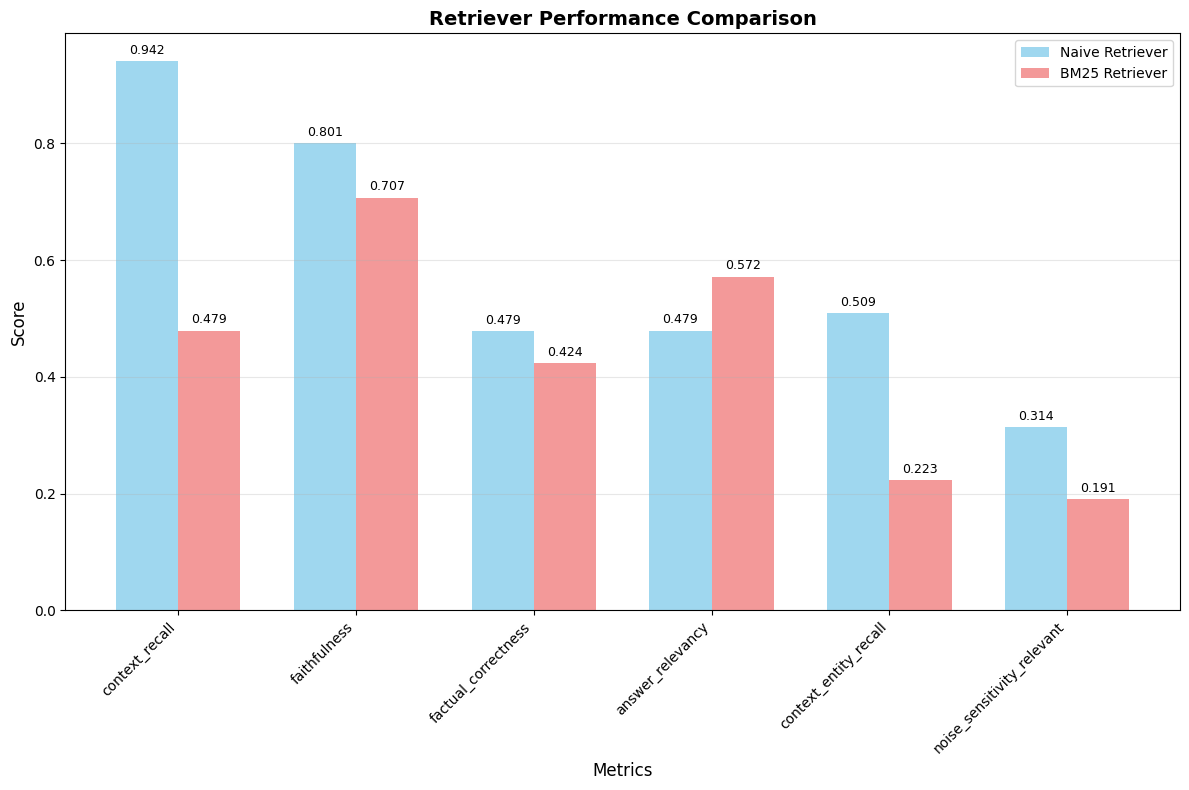

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set positions for bars
x = np.arange(len(metrics))
width = 0.35

# Create grouped bars
bars1 = ax.bar(x - width/2, naive_values, width, label='Naive Retriever', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, bm25_values, width, label='BM25 Retriever', alpha=0.8, color='lightcoral')

# Customize the plot
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Retriever Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

